In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
from helper.manage_orderbooks_v2 import extract_orderbooks_for_one_currencypair, load_orderbook_snapshot, plot_episode
from helper.orderbook_container import OrderbookContainer
from helper.orderbook_trader import OrderbookTradingSimulator

In [3]:
filename = '3000orderbooks'
data = load_orderbook_snapshot(filename, last_line=120)

100%|██████████| 120/120 [00:03<00:00, 34.10it/s]

Loaded 120 orderbooks from file '3000orderbooks'.


#### Test Orderbook plot, print and compare_with

,Amount,Type
703.500000,1.461657,bid
703.700000,0.001250,bid
705.000000,0.158232,bid
705.224976,NaN,center
705.450000,3.172181,ask
706.170000,0.052838,ask
706.190000,0.645323,ask


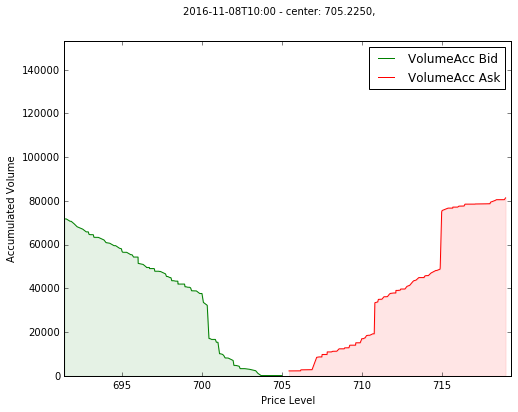

OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T10:01
  499 bids (best: 703.8)
  406 asks (best: 705.45)
  kind: 'orderbook'


In [4]:
orderbook = data[0]
orderbook2 = data[1]
orderbook3 = data[2]

display(orderbook.head(3))
orderbook.plot(range_factor=1.02)  # outfile='sample.pdf')
print(orderbook)
print(orderbook2)

In [5]:
orderbook = data[0]
orderbook2 = data[1]

display(orderbook.head())
display(orderbook2.head())

print("\nCompare two orderbooks:")
diff = orderbook2.compare_with(other=orderbook)

display(diff.head(10))
print(diff)

,Amount,Type
703.500000,1.461657,bid
703.700000,0.001250,bid
705.000000,0.158232,bid
705.224976,NaN,center
705.450000,3.172181,ask
706.170000,0.052838,ask
706.190000,0.645323,ask


,Amount,Type
703.360000,1.700000,bid
703.700000,0.001250,bid
703.800000,5.276769,bid
704.624678,NaN,center
705.450000,5.049153,ask
706.170000,0.052838,ask
706.190000,0.645323,ask



Compare two orderbooks:


,Amount,Type
694.84,-0.334889,bid
694.01,-0.386696,bid
689.07,0.431199,bid
688.40,-0.432340,bid
685.11,-0.473604,bid
683.92,0.472354,bid
678.34,-0.511551,bid
678.31,0.510201,bid
674.59,-0.546871,bid
673.62,0.545428,bid


OrderbookContainer from 2016-11-08T10:00
  23 bids (best: 673.62)
  27 asks (best: 705.45)
  kind: 'diff'


episode_length 120
episode_windows[0] = orderbooks[0:120], length=120

Episodes: 1, orderbooks per episode: 120


,Amount,Type
703.500000,1.461657,bid
703.700000,0.001250,bid
705.000000,0.158232,bid
705.224976,NaN,center
705.450000,3.172181,ask
706.170000,0.052838,ask
706.190000,0.645323,ask


,Amount,Type
705.09000,1.591694,bid
705.50000,3.009879,bid
706.00000,7.277076,bid
706.90961,NaN,center
707.82000,5.027350,ask
707.83000,0.006685,ask
707.86000,0.013980,ask


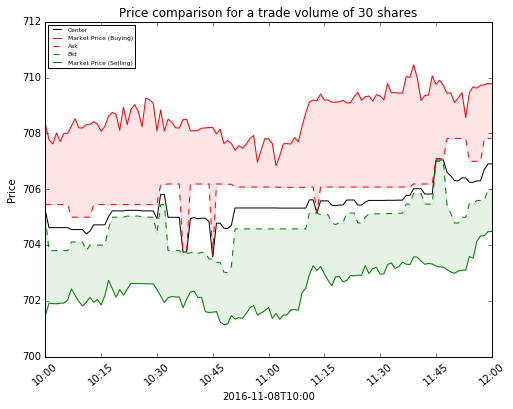

In [6]:
P = 10
vol=30
T = 12
episode_length = T*P
print("episode_length", episode_length)
episodes = int(len(data) / episode_length)

episode_windows = []
for e in range(0, episodes):
    episode_start = e*episode_length
    episode_end = (e+1)*episode_length
    window = [ob.copy() for ob in data[episode_start:episode_end]]
    print("episode_windows[{}] = orderbooks[{}:{}], length={}".format(e, episode_start, episode_end, len(window)))
    
    # window = [orderbooks[e*episode_length + idx].copy() for idx in range(episode_length)]
    episode_windows.append(window)
    
print("\nEpisodes: {}, orderbooks per episode: {}".format(len(episode_windows), len(episode_windows[0])))

ob = episode_windows[0][0]
ob2 = episode_windows[0][-1]
display(ob.head(3))
display(ob2.head(3))
plot_episode(episode_windows[0], volume=vol)

#### Test get_current_price()

In [7]:
display(orderbook.head(3))
vol = 10

for factor in [0.25, 0.5, 0.75, 1.]:
    res = orderbook.get_current_price(vol*factor)
    print("MarketOrderPrice for {} shares: {:1.4f} (worst price: {})".format(vol*factor, res[0], res[1]))

,Amount,Type
703.500000,1.461657,bid
703.700000,0.001250,bid
705.000000,0.158232,bid
705.224976,NaN,center
705.450000,3.172181,ask
706.170000,0.052838,ask
706.190000,0.645323,ask


MarketOrderPrice for 2.5 shares: 1763.6250 (worst price: 705.45)
MarketOrderPrice for 5.0 shares: 3529.6894 (worst price: 707.18)
MarketOrderPrice for 7.5 shares: 5297.6394 (worst price: 707.18)
MarketOrderPrice for 10.0 shares: 7065.5894 (worst price: 707.18)


#### Test orderbook.head and tail

In [8]:
display(orderbook.head(2))
display(orderbook.tail(2))

,Amount,Type
703.700000,0.001250,bid
705.000000,0.158232,bid
705.224976,NaN,center
705.450000,3.172181,ask
706.170000,0.052838,ask


,Amount,Type
614.000000,1.838163,bid
614.320000,0.034763,bid
705.224976,NaN,center
810.000000,0.286798,ask
811.000000,0.000100,ask


#### Test parameter limit

In [9]:
len(episode_windows[0])

120

In [10]:
P = 4
vol=100
T = 2
ots = OrderbookTradingSimulator(orderbooks=episode_windows[0][:T*P], volume=vol, tradingperiods=T,
                                decisionfrequency=P)

for e in tqdm(range(T)):
    summary = ots.trade(limit=706, verbose=True)

display(ots.history)
display(summary)


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

t=3: Traded 6.8581/100.0000 shares for -4838.0505884655, 93.1419 shares left
Run out of time (t=7).
Trade remaining 91.3880/100.0000 shares for current market order price
t=7: Traded 93.1419/93.1419 shares for -66342.87927223179, 0.0000 shares left


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T10:00,705.45,705.0,705.224976,706,0.45,4,100.000000,705.45000,-4838.050588,0.002188,0,False,705.45,705.45,6.858106
2016-11-08T10:04,705.45,703.8,704.624678,706,1.65,4,93.141894,712.27754,-66342.879272,0.931460,0,True,715.00,705.00,93.141894


{'amount': 100.0,
 'cashflow': -71180.929860697288,
 'cost': 0.93364872901170792,
 'remaining': 0.0}

In [11]:
P = 2
vol=100
T = 4
ots = OrderbookTradingSimulator(orderbooks=episode_windows[0][:T*P], volume=vol, tradingperiods=T,
                                decisionfrequency=P)

for e in tqdm(range(T)):
    summary = ots.trade(limit=706, verbose=True)

display(ots.history)
display(summary)


 75%|███████▌  | 3/4 [00:00<00:00, 26.19it/s]

t=1: Traded 5.0492/100.0000 shares for -3561.92484276, 94.9508 shares left
t=3: Traded 1.8090/94.9508 shares for -1276.1257457055003, 93.1419 shares left
t=5: Traded 1.7539/93.1419 shares for -1237.3049591865, 91.3880 shares left
Run out of time (t=7).
Trade remaining 91.3880/100.0000 shares for current market order price


100%|██████████| 4/4 [00:00<00:00, 15.15it/s]

t=7: Traded 91.3880/91.3880 shares for -65105.57431304529, 0.0000 shares left


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T10:00,705.45,705.0,705.224976,706,0.45,2,100.000000,705.45000,-3561.924843,0.001611,0,False,705.45,705.45,5.049153
2016-11-08T10:02,705.45,703.8,704.624678,706,1.65,2,94.950847,705.45000,-1276.125746,0.000577,0,False,705.45,705.45,1.808953
2016-11-08T10:04,705.45,703.8,704.624678,706,1.65,2,93.141894,705.45000,-1237.304959,0.000560,0,False,705.45,705.45,1.753923
2016-11-08T10:06,706.17,703.8,704.984336,706,2.37,2,91.387971,712.40857,-65105.574313,0.930900,0,True,715.00,705.00,91.387971


{'amount': 100.0,
 'cashflow': -71180.929860697288,
 'cost': 0.93364814290539599,
 'remaining': 0.0}

#### Test parameter aggression_factor

In [12]:
P = 2
vol=100
T = 4
ots = OrderbookTradingSimulator(orderbooks=episode_windows[0][:T*P], volume=vol, tradingperiods=T,
                                decisionfrequency=P)

for e in tqdm(range(T)):
    action=0.9
    summary = ots.trade(agression_factor=action, verbose=True, extrainfo={'ACTION':action})
display(ots.history)

 25%|██▌       | 1/4 [00:00<00:00,  7.58it/s]

t=1: Traded 73.9685/100.0000 shares for -52491.6620519652, 26.0315 shares left


100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

t=3: Traded 8.0514/26.0315 shares for -5690.639731756701, 17.9802 shares left
t=5: Traded 1.8201/17.9802 shares for -1284.1296028907, 16.1600 shares left
Run out of time (t=7).
Trade remaining 14.3680/100.0000 shares for current market order price
t=7: Traded 16.1600/16.1600 shares for -11486.057814624499, 0.0000 shares left


,ACTION,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded,LIMIT_MAX
2016-11-08T10:00,0.9,705.45,705.0,705.224976,714.045,0.45,2,100.000000,709.64918,-52491.662052,0.464039,0,False,714.00,705.45,73.968467,715.0
2016-11-08T10:02,0.9,705.45,703.8,704.624678,714.045,1.65,2,26.031533,706.79154,-5690.639732,0.017885,0,False,709.00,705.45,8.051369,715.0
2016-11-08T10:04,0.9,705.45,703.8,704.624678,714.045,1.65,2,17.980163,705.51293,-1284.129603,0.000743,0,False,707.18,705.45,1.820136,715.0
2016-11-08T10:06,0.9,710.32,703.8,707.054990,714.532,6.52,2,16.160027,710.76971,-11486.057815,0.127056,0,True,714.35,705.00,16.160027,715.0
